**21C29027 - Đặng Thị Lệ Uyên**

# Bài tập cuối kỳ 
## Phần 2 - Xóa ngẫu nhiên một số ngày của dữ liệu và phân tích

1. Xóa ngẫu nhiên một số ngày của dữ liệu
2. Phân tích bộ dữ liệu mới
    - Tìm hiểu dữ liệu: 
      - Trực quan hoá dữ liệu
      - Kiểm tra xem dữ liệu có bị khuyết hay có các giá trị ngoại lai hay không
      - Phân tích và đưa ra một số nhận định ban đầu về dữ liệu.
      - Xử lý dữ liệu khuyết
    - Kiểm tra tính stationarity của dữ liệu
    - Nếu dữ liệu có trend hoặc/và seasonality thì loại bỏ chúng
    - Chọn mô hình phù hợp 
    - Kiểm định mô hình đã chọn
    - Dự báo
    - Đánh giá mô hình
    - Kết luận

## Giới thiệu về dữ liệu Walmart

Bộ dữ liệu Walmart gồm 5 năm dữ liệu bán hàng của 10 cửa hàng hàng với 50 sản phẩm khác nhau của Walmart, được chia sẵn thành hai tập training và test, mỗi tập gồm có 4 features sau: 

- date - ngày tháng năm
- store - ID của cửa hàng, ID từ 1 đến 10.
- item - ID của sản phẩm, ID từ 1 đến 50
- sales - Số lượng sản phẩm được bán ra.

Link lấy dữ liệu: https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data

Đây là bộ dữ liệu khá lớn nên để đơn giản hoá bài toán, bài tập này em sẽ chọn ngẫu nhiên một sản phẩm và một cửa hàng trong bộ dữ liệu để phân tích.
Ngày nộp bài là 17 nên em chọn store = 1 và item = 7.

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import copy
from scipy import stats
from statsmodels.tsa.api import adfuller, kpss, seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
import missingno as msno

import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [16, 7]

In [2]:
# Load the data
df = pd.read_csv('./Data/train.csv', parse_dates=['date'])
# Choose a subset of the data with store = 1 and item = 7
store_17 = df.query('store == 1 and item == 7').reset_index(drop=True).drop(['store', 'item'], axis=1)

### 1. Xóa ngẫu nhiên một số ngày của dữ liệu

Xóa ngẫu nhiên 5% dữ liệu gốc

In [3]:
missing_store_17 = copy.deepcopy(store_17)

np.random.seed(10)

# Thay thế ngẫu nhiên 5% dữ liệu bằng NaN
remove_n = int(0.05 * missing_store_17.shape[0]) # 182 items bị xóa

drop_indices = np.random.choice(missing_store_17.index, remove_n, replace=False)
missing_store_17['sales'].loc[drop_indices] = np.nan

### 2. Phân tích bộ dữ liệu mới
### a. Tìm hiểu tập dữ liệu 

In [4]:
# Display some rows of the data
display(missing_store_17.head())

# The shape of the data
print(missing_store_17.shape)

# The info of the dataset
print(missing_store_17.info())

# Printing the statistical descriptions of the data
display(missing_store_17.describe())

,date,sales
0,2013-01-01,25.0
1,2013-01-02,23.0
2,2013-01-03,34.0
3,2013-01-04,36.0
4,2013-01-05,38.0


(1826, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1826 non-null   datetime64[ns]
 1   sales   1735 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.7 KB
None


,sales
count,1735.000000
mean,52.827089
std,15.112651
min,14.000000
25%,42.000000
50%,52.000000
75%,63.000000
max,115.000000


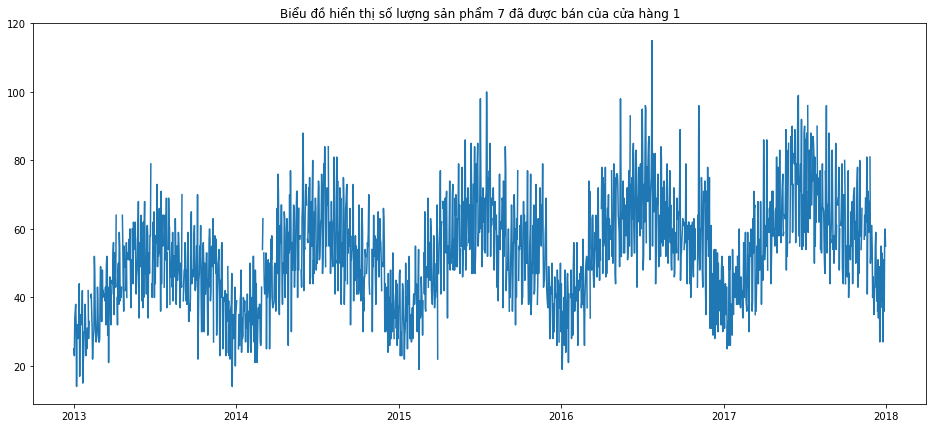

In [5]:
plt.plot(missing_store_17['date'], missing_store_17['sales'])
plt.title('Biểu đồ hiển thị số lượng sản phẩm 7 đã được bán của cửa hàng 1')
plt.show()

Một số nhận xét ban đầu về tập dữ liệu:
- Tập dữ liệu gồm 1826 quan sát, có một số dữ liệu bị khuyết ở cột 'sales'
- Ngày bán thấp nhất là 14 sản phẩm
- Ngày bán cao nhất là 115 sản phẩm
- Trung bình một ngày bán được gần 53 sản phẩm
- Tập dữ liệu có tính chu kỳ theo năm

In [5]:
print(f'Tổng số dòng bị khuyết: \n {missing_store_17.isna().sum()}')
missing_store_17[missing_store_17['sales'].isna() == True].head(15)

Tổng số dòng bị khuyết: 
 date      0
sales    91
dtype: int64


,date,sales
31,2013-02-01,NaN
35,2013-02-05,NaN
36,2013-02-06,NaN
37,2013-02-07,NaN
67,2013-03-09,NaN
96,2013-04-07,NaN
108,2013-04-19,NaN
115,2013-04-26,NaN
120,2013-05-01,NaN
130,2013-05-11,NaN


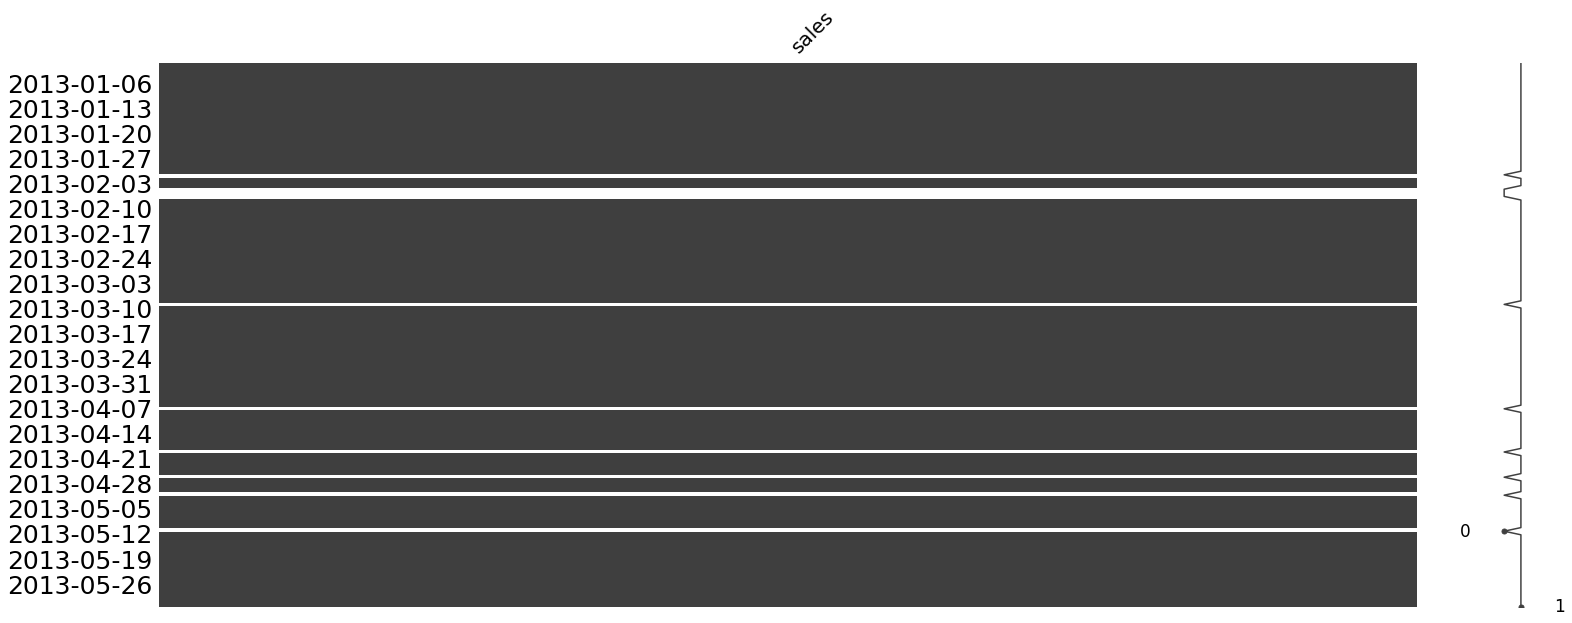

In [6]:
ts_df = missing_store_17.set_index("date")
msno.matrix(ts_df["2013-01-01": "2013-06-01"], freq="W", fontsize=20)
plt.show()

- Tổng số dòng bị khuyết là 91 dòng
- Các dòng dữ liệu bị khuyết dường như không liên quan đến nhau

#### Tách 'date' thành ngày trong tuần, tháng, năm

In [26]:
store_1_7 = copy.deepcopy(missing_store_17)
store_1_7['year']=store_1_7.date.dt.year
store_1_7['month']=store_1_7.date.dt.month
store_1_7['day'] = store_1_7.date.dt.dayofyear
store_1_7['weekday'] = store_1_7.date.dt.weekday
store_1_7['week'] = store_1_7.date.dt.week
store_1_7['year-month'] = store_1_7.date.apply(lambda x: str(x.year)+'-'+str(x.month))
store_1_7.set_index('date', inplace=True)
store_1_7.head()

,sales,year,month,day,weekday,week,year-month
date,,,,,,,
2013-01-01,25.0,2013,1,1,1,1,2013-1
2013-01-02,23.0,2013,1,2,2,1,2013-1
2013-01-03,34.0,2013,1,3,3,1,2013-1
2013-01-04,36.0,2013,1,4,4,1,2013-1
2013-01-05,38.0,2013,1,5,5,1,2013-1


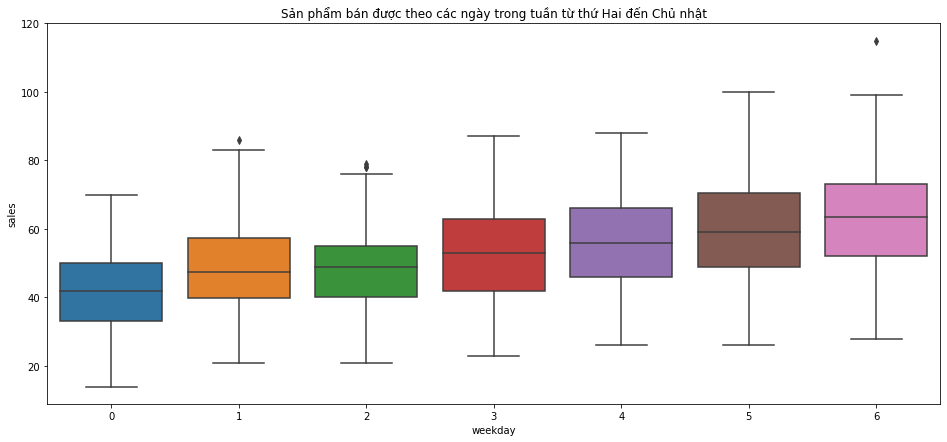

In [27]:
# Plot the data
sns.boxplot(x="weekday", y="sales", data=store_1_7)
plt.title("Sản phẩm bán được theo các ngày trong tuần từ thứ Hai đến Chủ nhật")
plt.show()

Biểu đồ trên cho thấy:
- Thứ Hai (weekday=0) sản phẩm bán được ít hơn các ngày khác
- Hai ngày cuối tuần thứ 7 (weekday=5) và chủ nhật (weekday=6) bán được nhiều sản phẩm nhất. 
- Thứ 3, thứ 4 và chủ nhật có các giá trị ngoại lai.

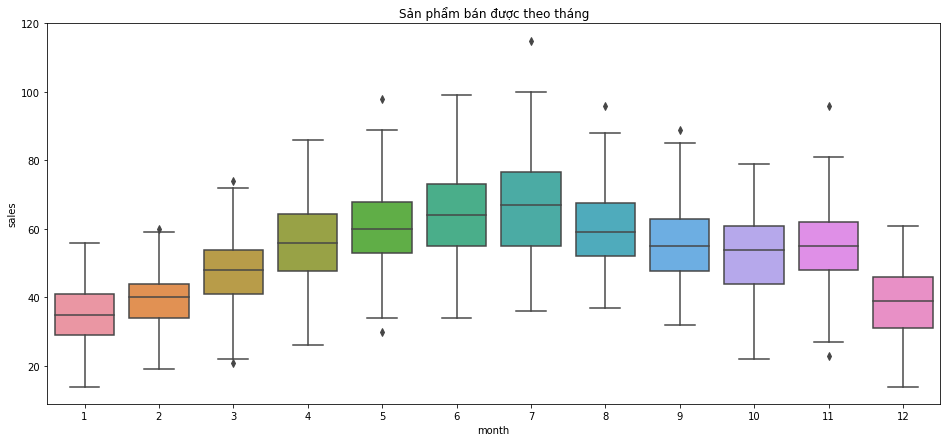

In [97]:
sns.boxplot(x="month", y="sales", data=store_1_7)
plt.title("Sản phẩm bán được theo tháng")
plt.show()

- Tháng 7 là tháng sản phẩm 7 của cửa hàng 1 được bán nhiều nhất so với các tháng khác trong năm, tháng 1 và tháng 12 bán được ít sản phẩm này nhất
- Có một số giá trị ngoại lai, đặc biệt trong tháng 7 và tháng 11

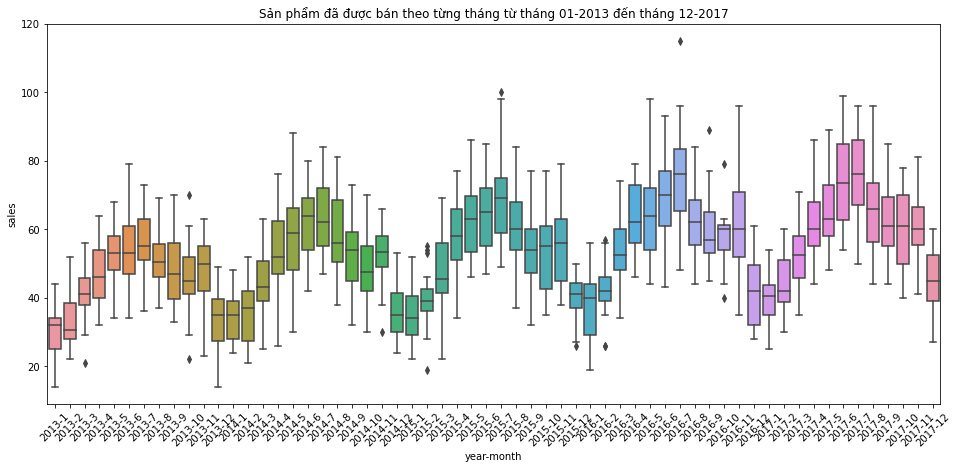

In [98]:
# Plot the data
plt.xticks(rotation=45)
plt.title('Sản phẩm đã được bán theo từng tháng từ tháng 01-2013 đến tháng 12-2017')
sns.boxplot(x="year-month", y="sales", data=store_1_7)
plt.show()

- Biểu đồ này cho thấy dữ liệu có tính chu kỳ và tính trend.
- Có các giá trị ngoại lai trong một vài tháng, năm 2016 có khá nhiều giá trị ngoại lai cần chú ý.

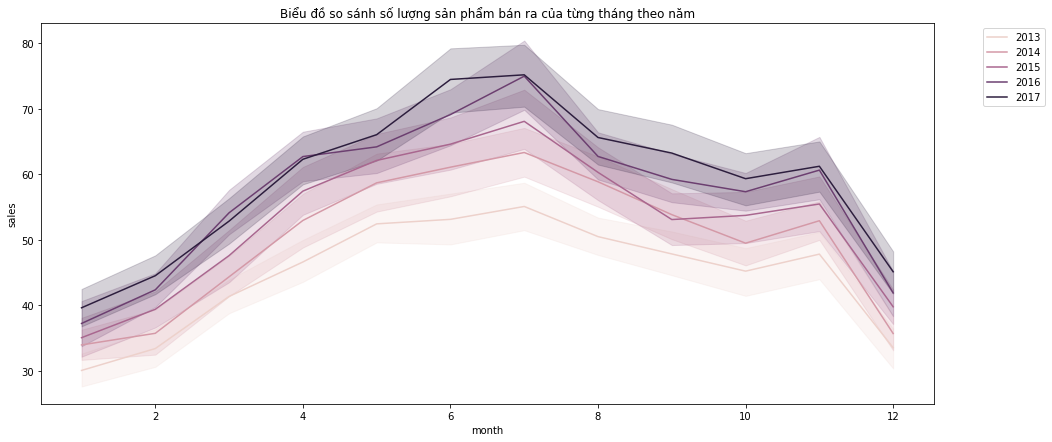

In [99]:
sns.lineplot(data=store_1_7, 
             x='month', 
             y='sales', 
             hue='year', 
             legend='full')

plt.title('Biểu đồ so sánh số lượng sản phẩm bán ra của từng tháng theo năm')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);
plt.show()

- Dễ dàng thấy được trung bình số lượng sản phẩm bán được tăng theo từng năm (từ 2013 đến 2017).
- Trong mỗi năm, tháng 1 bán được ít sản phẩm nhất và tháng 7 bán được nhiều sản phẩm nhất.

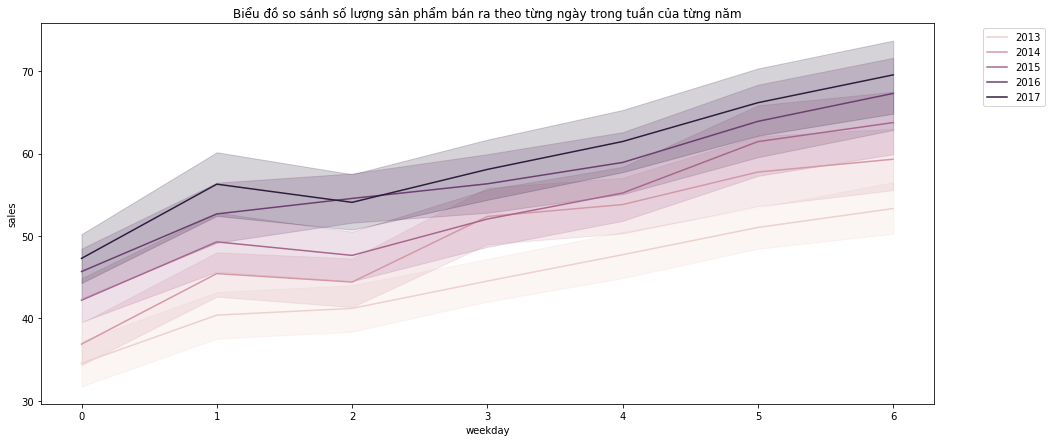

In [100]:
sns.lineplot(data=store_1_7, 
             x='weekday', 
             y='sales', 
             hue='year', 
             legend='full')

plt.title('Biểu đồ so sánh số lượng sản phẩm bán ra theo từng ngày trong tuần của từng năm')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2);
plt.show()

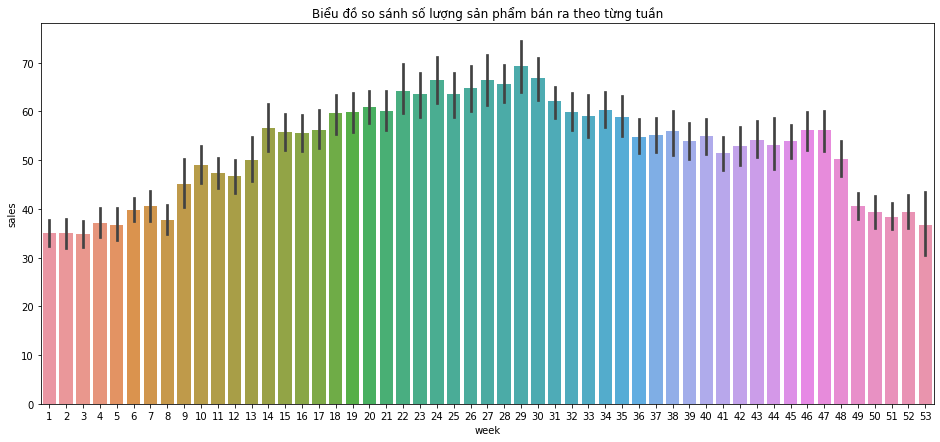

In [101]:
sns.barplot(x='week', y='sales', data=store_1_7)
plt.title('Biểu đồ so sánh số lượng sản phẩm bán ra theo từng tuần')
plt.show()

Vào tầm giữa năm, tuần 27 đến tuần 30, sản phẩm 7 của cửa hàng 1 bán được nhiều hơn so với các tuần khác

### b) Xử lý dữ liệu bị khuyết

- 1. Như đã nhận xét ở trên, số lượng bán hàng từ thứ Hai đến chủ nhật khác nhau, thứ Hai số lượng sản phẩm bán ra là ít nhất, nhiều nhất là vào thứ 7, chủ nhật nên ta sẽ điền khuyết bằng giá trị mean theo từng ngày trong tuần.
- 2. Vì số lượng sản phẩm bán ra của từng khác cũng có sự khác nhau (tháng 7 sản phẩm thường bán được nhiều nhất so với các tháng khác trong năm) nên ta sẽ xem xét điền khuyết bằng giá trị mean theo từng ngày trong tuần của từng tháng.


**Điền khuyết bằng mean theo từng ngày trong tuần**

In [4]:
#ts_df = missing_store_17.set_index("date")

null_mask = ts_df.sales.isnull()

# Creating a new column and artificially creating missing values
ts_df['sales_missing'] = ts_df.sales

#Create a column with the weekday from date
ts_df["weekday"] = ts_df.index.weekday

#Calculate weekday average sales
day_mean = ts_df.groupby(['weekday'])['sales'].mean().astype('int').reset_index()
day_mean.rename(columns={"sales": "day_mean"}, inplace=True)

#Saving the index because it gets lost in merge
idx = ts_df.index
#Merge the day_mean dataframe to ts dataframe
ts_df = ts_df.merge(day_mean, on=['weekday'], how='left', validate="many_to_one")
ts_df.index = idx

#Using the day profile to fill missing
ts_df['day_mean_imputed'] = ts_df['sales_missing']
ts_df.loc[null_mask,"day_mean_imputed"] = ts_df.loc[null_mask,"day_mean"]

**Điền khuyết bằng giá trị mean theo từng ngày trong tuần của từng tháng.**

In [5]:
#Create a column with the month from date
ts_df["month"] = ts_df.index.month

#Calculate weekday-monthly average sales
daymonth_mean = ts_df.groupby(['weekday', 'month'])['sales'].mean().astype('int').reset_index()
daymonth_mean.rename(columns={"sales": "daymonth_mean"}, inplace=True)

#Saving the index because it gets lost in merge
idx = ts_df.index
#Merge the daymonth_mean dataframe to ts dataframe
ts_df = ts_df.merge(daymonth_mean, on=['weekday', 'month'], how='left', validate="many_to_one")
ts_df.index = idx

#Using the daymonth_mean to fill missing
ts_df['daymonth_mean_imputed'] = ts_df['sales_missing']
ts_df.loc[null_mask,"daymonth_mean_imputed"] = ts_df.loc[null_mask,"daymonth_mean"]

In [6]:
# Display dataframe after imputing missing values by 2 above methods
window = slice("2017-01-01", "2017-12-01")

ts_df[ts_df['sales'].isna()==True].loc[window, ['day_mean_imputed', 'daymonth_mean_imputed']]

,day_mean_imputed,daymonth_mean_imputed
date,,
2017-01-31,48.0,32.0
2017-03-14,48.0,43.0
2017-04-11,48.0,49.0
2017-05-17,48.0,57.0
2017-05-28,62.0,70.0
2017-06-07,48.0,55.0
2017-06-20,48.0,59.0
2017-07-08,60.0,77.0
2017-07-29,60.0,77.0


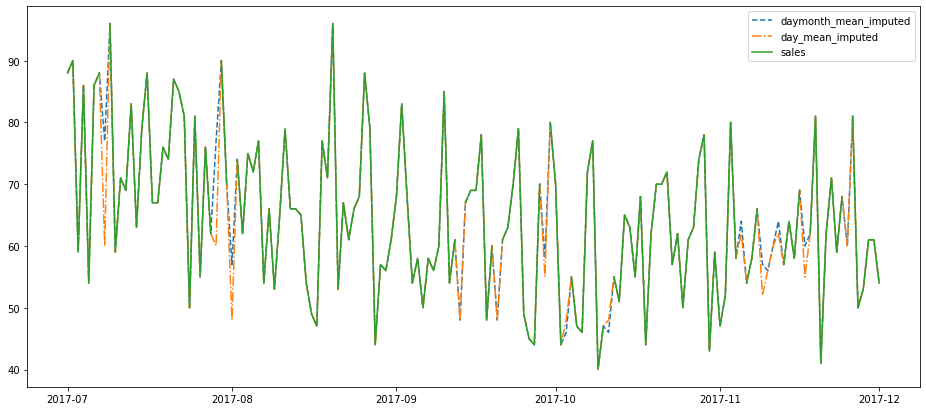

In [10]:
# plot lines
window2 = slice("2017-07-01", "2017-12-01")

plt.plot(ts_df.loc[window2,['daymonth_mean_imputed']], label = "daymonth_mean_imputed", linestyle='--')
plt.plot(ts_df.loc[window2,['day_mean_imputed']], label = "day_mean_imputed", linestyle='-.')
plt.plot(ts_df.loc[window2,['sales']], label = "sales")
plt.legend()
plt.show()

Vì dữ liệu này có tính chu kỳ theo tuần, tháng, năm nên điền khuyết theo cách thứ 2 có thể sẽ phù hợp hơn, nên ta sẽ sử dụng dữ liệu được điền khuyết theo tuần và tháng để phân tích tiếp.

### c) Kiểm tra các giá trị ngoại lai

Trong bước trực quan hoá dữ liệu ở trên, nhận thấy có một số giá trị ngoại lai nên ta sẽ kiểm tra các giá trị ngoại lai này có phải là cực ngoại lai hay không.

In [11]:
def iqr_extreme_outliers(series):
    q1, q3 = np.percentile(series, [25, 75])
    IQR = q3 - q1
    lower_fence = q1 - (3 * IQR)
    upper_fence = q3 + (3 * IQR)
    extreme_outliers = []
    for i in range(len(series)):
        if (series[i] > upper_fence) | (series[i] < lower_fence):
            extreme_outliers.append(series[i])
    return extreme_outliers

extreme_outliers = iqr_extreme_outliers(ts_df['daymonth_mean_imputed'])
print(f'Số lượng các giá trị cực ngoại lai = {len(extreme_outliers)}')

Số lượng các giá trị cực ngoại lai = 0


Vì tập dữ liệu này không có giá trị cực ngoại lai nên ta sẽ chấp nhận các giá trị ngoại lai như một phần của dữ liệu và tiếp tục phân tích.

### d) Kiểm tra tính stationarity của dữ liệu sau khi điền khuyết

In [7]:
new_store_17 = ts_df[['sales', 'day_mean_imputed', 'daymonth_mean_imputed']]

In [13]:
def check_stationarity(df, maxlag):
    adf_results = adfuller(df, maxlag=maxlag, autolag=None)[1:3]
    kpss_results = kpss(df, nlags=maxlag)[1:3]
    adf_s = 'Non-Stationary'
    kpss_s = 'Non-Stationary'
    if adf_results[0] < 0.05:
        adf_s = 'Stationary'
    if kpss_results[0] > 0.05:
        kpss_s = 'Stationary'

    tests = ['ADF', 'KPSS']
    pvalues = [adf_results[0], kpss_results[0]]
    is_stationary = [adf_s, kpss_s]
    stationary_df = pd.DataFrame({'tests': tests, 'p-value': pvalues, 'is_stationary': is_stationary})

    return stationary_df
    
print('With lags=7:')
display(check_stationarity(new_store_17['daymonth_mean_imputed'], 7))
print('With lags=365:')
display(check_stationarity(new_store_17['daymonth_mean_imputed'], 365))

With lags=7:


,tests,p-value,is_stationary
0,ADF,0.007105,Stationary
1,KPSS,0.010000,Non-Stationary


With lags=365:


,tests,p-value,is_stationary
0,ADF,0.104798,Non-Stationary
1,KPSS,0.019863,Non-Stationary


- Kiểm tra tính stationarity của dữ liệu theo tuần:
  - Kiểm định Augmented Dickey-Fuller cho kết quả Stationary
  - Tuy nhiên kiểm định KPSS cho kết quả non-stationary.
- Kiểm tra tính stationarity của dữ liệu theo năm: 
  - Cả hai kiểm định Augmented Dickey-Fuller và KPSS đều cho kết quả non-stationary.

Do đó, ta sẽ cần phải đưa dữ liệu về stationary

### e) Seasonal Decomposition

Theo quan sát ban đầu, dữ liệu này có tính chu kỳ theo tuần và theo năm, nên hàm MSTL (Season-Trend decomposition using LOESS for multiple seasonalities) được sử dụng để phân rã chuỗi.

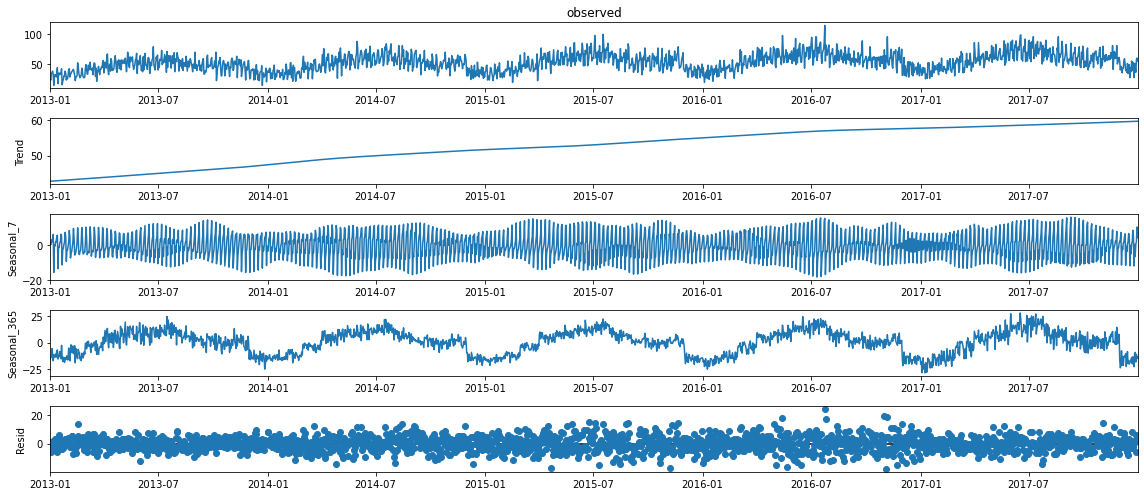

In [14]:
from statsmodels.tsa.seasonal import MSTL

week = 7
year = 365

mstl = MSTL(new_store_17['daymonth_mean_imputed'], periods=(week, year))
results = mstl.fit()
results.plot()
plt.show()

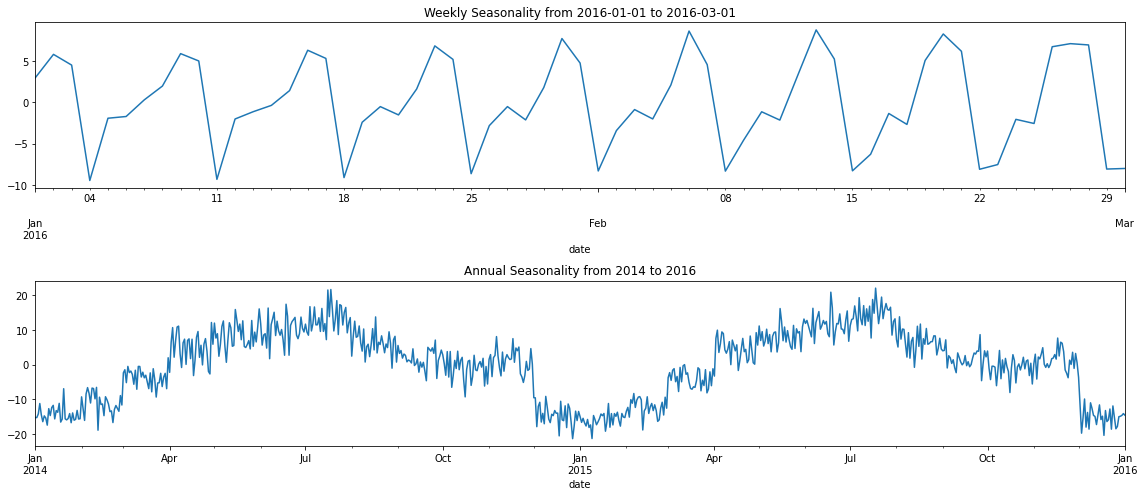

In [15]:
fig, ax = plt.subplots(2, 1)
(results.seasonal['seasonal_7'].loc['2016-01-01':'2016-03-01']
 .plot(ax=ax[0],title='Weekly Seasonality from 2016-01-01 to 2016-03-01'))
(results.seasonal['seasonal_365'].loc['2014-01-01':'2016-01-01']
 .plot(ax=ax[1],title='Annual Seasonality from 2014 to 2016'))
fig.tight_layout()
plt.show()

Vì dữ liệu là non-stationary và có tính chu kỳ theo tuần và theo năm nên ta sẽ xem xét sử dụng mô hình TBATS, BATS và SARIMAX + Fourier terms.

Link tham khảo: https://robjhyndman.com/hyndsight/dailydata/

In [8]:
# Chia tập dữ liệu thành 2 phần để train và kiểm định
def split_data(data, t_idx):
    train, val = data[ : -t_idx], data[-t_idx : ]
    print(f'train: {len(train)} , val: {len(val)}')
    return train, val

# Use 1 last year to validate model
t_idx = 365
train, val = split_data(new_store_17, t_idx)

train: 1461 , val: 365


### f) Chọn mô hình phù hợp 

  ### i) Mô hình  SARIMAX + Fourier terms:
  
  Để áp dụng mô hình SARIMA, ta cần xác định d, p, q
  - Xác định d bằng cách áp dụng differencing lên dữ liệu gốc
  - Xác định q dựa vào ACF plot
  - Xác định p dựa vào PACF plot

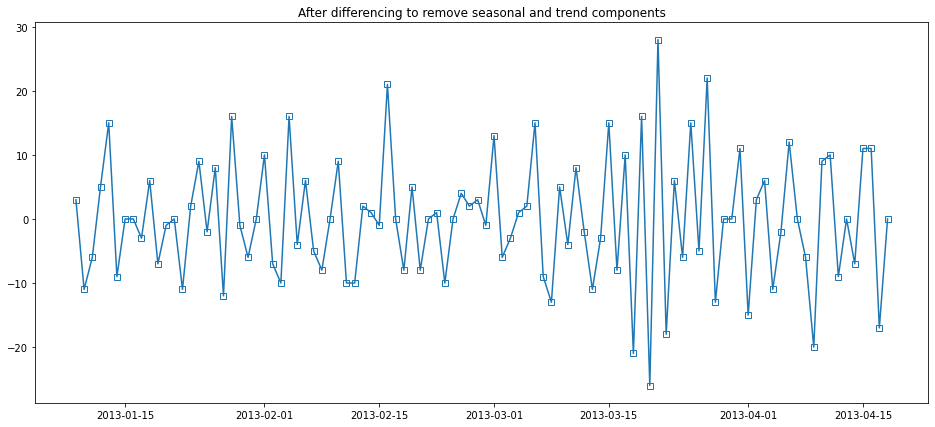

In [17]:
lag=7
index=new_store_17.index[lag+1:]
store_17_diff = new_store_17['daymonth_mean_imputed'].diff(lag).diff().dropna()
plt.plot(store_17_diff[:100], marker='s', mfc='none')
plt.title("After differencing to remove seasonal and trend components")
plt.show()

In [57]:
display(check_stationarity(store_17_diff, 1))

,tests,p-value,is_stationary
0,ADF,0.0,Stationary
1,KPSS,0.1,Stationary


Dữ liệu sau khi được transform và differencing d = 1 và D = 1 đã trở thành stationary.

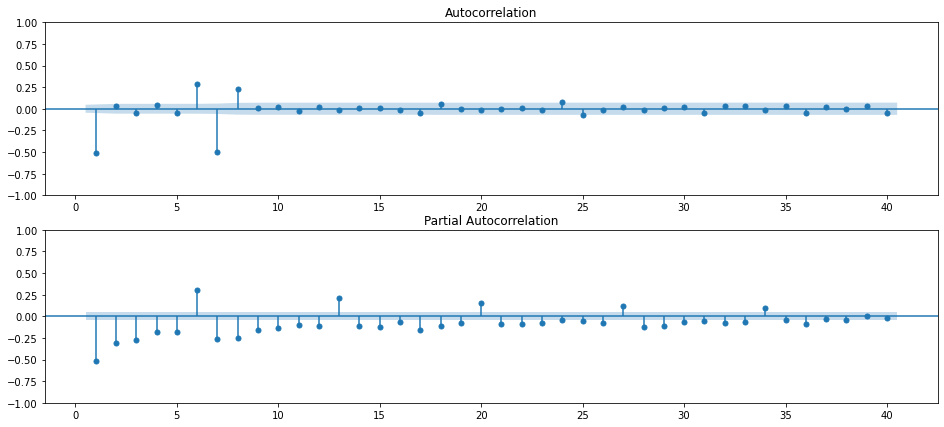

In [58]:
from statsmodels.graphics.tsaplots import plot_acf, acf, plot_pacf

# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1)

# Plot the ACF on ax1
plot_acf(store_17_diff, lags=40, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(store_17_diff, lags=40, zero=False, ax=ax2)

plt.show()

Biểu đồ ACF:
  - Tại lag 1 và lag 6, ta thấy giá trị nằm ngoài bound $+-1.96/\sqrt{n}$: ta sẽ xem xét q = 1 hoặc q = 6.
  - Theo chu kỳ tuần 7 ngày, thì lag 7 giá trị nằm ngoài bound, nhưng tại các lag thứ 14, 21, .... thì các giá trị này đều nằm xung quanh 0, nên ta sẽ xem xét Q = 1.
  
Biểu đồ PACF:
  - Trong 40 lags đầu tiên này, hầu hết các giá trị đều nằm ngoài bound nên ta chọn p = 0 và P = 0.
  
  Tuy nhiên trong bài này, ta sẽ dùng mô hình auto_arima để tìm kiếm mô hình SARIMA phù hợp nhất với bộ dữ liệu.

In [9]:
from statsmodels.tsa.deterministic import Fourier, DeterministicProcess

index = train.index
four = Fourier(period=365.25, order=1)
det_proc = DeterministicProcess(index, additional_terms=[four])
det_terms = det_proc.in_sample()

In [10]:
from pmdarima import auto_arima

mod = auto_arima(y=train['daymonth_mean_imputed'], D=1, seasonal=True, m=7, exog=det_terms)
print(mod.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1461
Model:             SARIMAX(0, 0, 5)x(0, 1, [1], 7)   Log Likelihood               -5190.619
Date:                             Fri, 16 Dec 2022   AIC                          10395.237
Time:                                     11:34:31   BIC                          10432.212
Sample:                                 01-01-2013   HQIC                         10409.033
                                      - 12-31-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1238      0.025      5.014      0.000       0.075       0.172
ma.L2          0.1554      

#### **Kiểm định mô hình SARIMAX + Fourier terms**

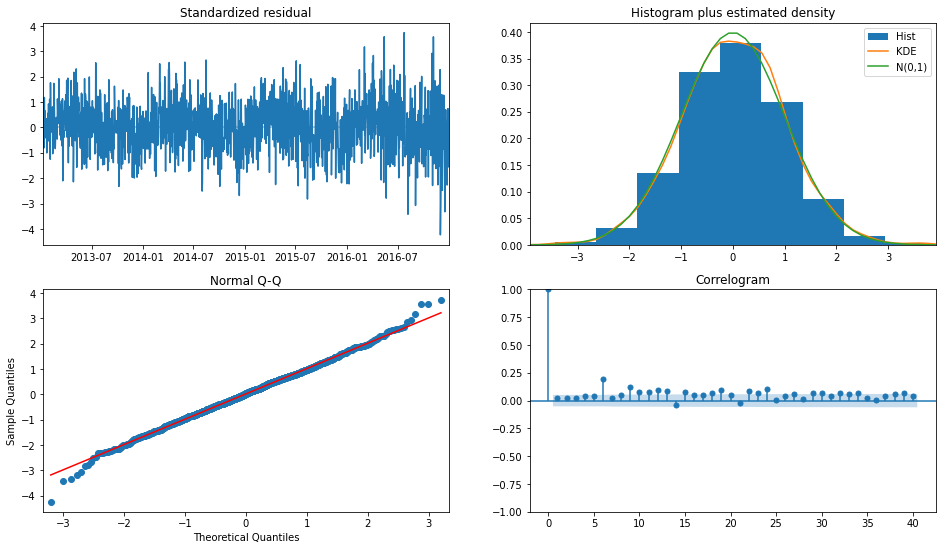

In [14]:
mod.plot_diagnostics(lags=40, figsize=(16, 9))
plt.show()

- Biểu đồ Histogram và summary của mô hình (Skew = -0.01, Kurtosis: 3.32) cho thấy phần dư này xấp xỉ phân phối chuẩn. 
- Biểu đồ Normal Q-Q cho thấy mô hình fit khá tốt, trừ các điểm nằm 2 góc trên và dưới.
- Biểu đồ Correlogram: Trong 40 lags đầu, có khá nhiều giá trị nằm ngoài bounds cho ta thấy residuals của mô hình này có khả năng có sự tương quan với nhau.

Vì phần dư của mô hình không có tính độc lập nên khả năng cao đây không phải là mô hình phù hợp với tập dữ liệu.

### ii) Mô hình TBATS

In [15]:
from tbats import TBATS

period_1 = 7.0
period_2 = 365.25

tbats_model = TBATS(seasonal_periods=(period_1, period_2), use_trend=True)  

tbats_results = tbats_model.fit(train['daymonth_mean_imputed'])

print(tbats_results.summary())

/home/uyen/anaconda3/lib/python3.9/site-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


Use Box-Cox: False
Use trend: True
Use damped trend: True
Seasonal periods: [  7.   365.25]
Seasonal harmonics [3 3]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.131886
Trend (Beta): -0.000473
Damping Parameter (Phi): 0.805412
Seasonal Parameters (Gamma): [ 0.00093376  0.00024275 -0.00014628  0.00024569]
AR coefficients []
MA coefficients []
Seed vector [32.00267255  1.15440087 -7.2114422  -0.88075968  3.86044452 -1.75731325
  4.22972944  1.67324004 -2.03349161  1.38756135 -1.14790219 -2.10437308
 -2.80661348 -1.76481384]

AIC 16717.274275


**Kiểm định mô hình TBATS**

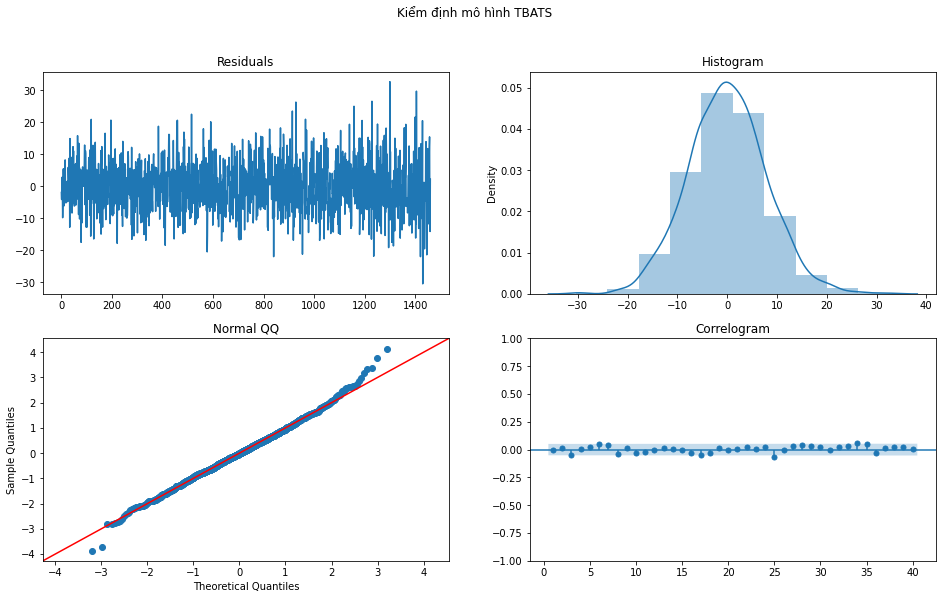

In [16]:
# Plot
from scipy.stats import norm
from statsmodels.graphics.gofplots import qqplot

f, (ax1, ax2) = plt.subplots(2, 2, figsize=(16,9))
ax1[0].plot(tbats_results.resid)
ax1[0].set_title('Residuals')

sns.distplot(tbats_results.resid, bins=10, ax=ax1[1])
ax1[1].set_title('Histogram')

qqplot(tbats_results.resid,norm,fit=True,line="45", ax=ax2[0])
ax2[0].set_title('Normal QQ')

plot_acf(tbats_results.resid, zero=False, lags=40, ax=ax2[1])
ax2[1].set_title('Correlogram')
plt.suptitle('Kiểm định mô hình TBATS')

plt.show()

- Biểu đồ Correlogram: các giá trị hầu như đều nằm trong bound cho thấy residuals của mô hình độc lập với nhau.
- Biểu đồ Histogram cho thấy phần dư này tuân theo phân phối chuẩn
- Biểu đồ Normal Q-Q cho thấy mô hình fit khá tốt, trừ các điểm nằm góc phía trên và phía dưới.

#### Kiểm định tính độc lập của residuals bằng phương pháp thống kê
- Kiểm định Durbin Watson:
    - $H_0$: Không có sự tương quan giữa residuals
    - $H_A$: Có sự tương quan giữa residuals
    
  p-value nằm trong khoảng (1.5, 2.5) của kiểm định Durbin Watson nói lên rằng phần dư có tính độc lập.
- Kiểm định Ljung-Box:
    - $H_0$: Residuals có tính độc lập
    - $H_A$: Residuals không có tính độc lập
    
  Kỳ vọng p-value > 0.05, vì nếu p-value > 0.05, ta không có cơ sở bác bỏ $H_0$, tức là phần dư có tính độc lập.

In [20]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox

print(f'Durbin Watson test: {durbin_watson(tbats_results.resid)}')
print('Ljung-box test: ')
acorr_ljungbox(tbats_results.resid, lags=5, return_df=True)

Durbin Watson test: 2.0073554805043927
Ljung-box test: 


,lb_stat,lb_pvalue
1,0.020420,0.886371
2,0.242372,0.885869
3,3.173176,0.365688
4,3.178999,0.528330
5,4.122343,0.531940


Kiểm định Durbin Watson và Ljung-Box đều có p-value > 0.05 nên ta nói rằng residuals của mô hình TBATS có tính độc lập.

#### Kiểm định tính chuẩn của residuals dựa trên Skewness và Kurtosis

- Skewness của phân phối chuẩn bằng 0 và bất kỳ dữ liệu đối xứng nào cũng phải có độ lệch gần bằng không. 
    - Skewness âm cho biết dữ liệu bị lệch trái
    - Skewness dương cho biết dữ liệu bị lệch phải
- Kurtosis của phân phối chuẩn là 3.0

In [21]:
from statsmodels.stats.descriptivestats import describe

print(f"Kurtosis: {describe(tbats_results.resid).loc['kurtosis']}")
print(f"Skew: {describe(tbats_results.resid).loc['skew']}")

Kurtosis: 0    3.47508
Name: kurtosis, dtype: float64
Skew: 0    0.109892
Name: skew, dtype: float64


Residuals của mô hình gần với phân phối chuẩn vì Kurtosis = 3.48 và skew = 0.1

### iii) Mô hình BATS

In [17]:
from tbats import BATS

period_1 = 7.0
period_2 = 365

bats_model = BATS(seasonal_periods=(period_1, period_2), use_trend=True)
bats_results = bats_model.fit(train['daymonth_mean_imputed'])

print(bats_results.summary())

Use Box-Cox: False
Use trend: True
Use damped trend: False
Seasonal periods: [  7 365]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.104674
Trend (Beta): -0.000014
Damping Parameter (Phi): 1.000000
Seasonal Parameters (Gamma): [-0.00535104 -0.36437883]
AR coefficients []
MA coefficients []
Seed vector [ 2.39295139e+01  1.05681359e-02 -1.10246665e+01  9.64261285e+00
  7.13483781e+00  2.25886602e+00 -1.82754702e-01 -4.15055967e+00
 -3.67833583e+00 -1.60225042e+01 -1.66907377e+01 -1.06359971e+01
 -1.61950785e+01 -2.11689185e+01 -1.86216007e+01 -1.49113835e+01
 -1.21985603e+01 -1.78667866e+01 -1.28120219e+01 -1.51211030e+01
 -1.78449492e+01 -1.12976496e+01 -2.18374379e+01 -1.48746032e+01
 -1.35428261e+01 -1.09880754e+01 -1.32971362e+01 -1.77709877e+01
 -1.54736971e+01 -1.42634881e+01 -1.53006440e+01 -1.27188592e+01
 -1.81640952e+01 -1.44731569e+01 -1.74470495e+01 -9.39973842e+00
 -1.29395154e+01 -2.02267035e+01 -1.36449110e+01 -4.84014943e+00
 -1.39919004e+00  4.87690345e+00 -5.75781640e

**Kiểm định mô hình BATS**

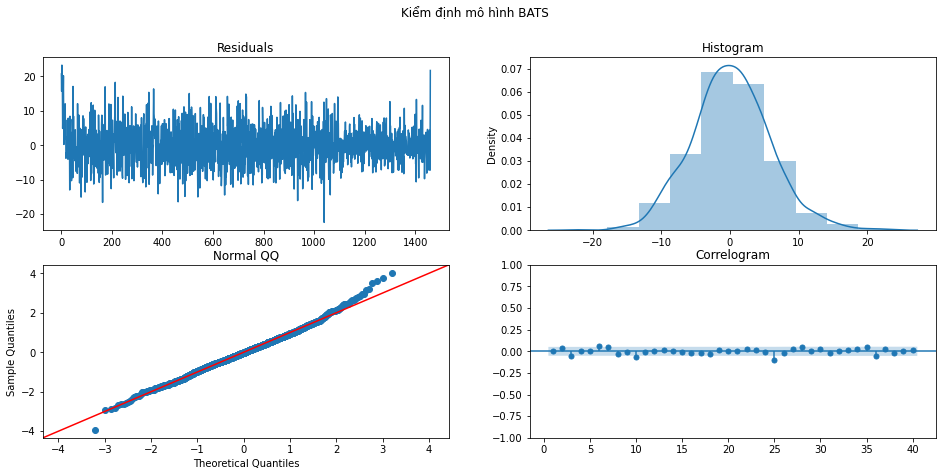

In [18]:
f, (ax1, ax2) = plt.subplots(2, 2)
ax1[0].plot(bats_results.resid)
ax1[0].set_title('Residuals')

sns.distplot(bats_results.resid, bins=10, ax=ax1[1])
ax1[1].set_title('Histogram')

qqplot(bats_results.resid,norm,fit=True,line="45", ax=ax2[0])
ax2[0].set_title('Normal QQ')

plot_acf(bats_results.resid, zero=False, lags=40, ax=ax2[1])
ax2[1].set_title('Correlogram')
plt.suptitle('Kiểm định mô hình BATS')
plt.show()

In [22]:
print(f'Durbin Watson test: {durbin_watson(bats_results.resid)}')
print('Ljung-box test: ')
acorr_ljungbox(bats_results.resid, lags=5, return_df=True)

Durbin Watson test: 1.9625823425342086
Ljung-box test: 


,lb_stat,lb_pvalue
1,0.110903,0.739119
2,1.876886,0.391236
3,5.760925,0.123839
4,5.885919,0.207831
5,5.932128,0.312879


Phần dư của mô hình BATS độc lập với nhau.

In [23]:
print(f"Kurtosis: {describe(bats_results.resid).loc['kurtosis']}")
print(f"Skew: {describe(bats_results.resid).loc['skew']}")

Kurtosis: 0    3.536967
Name: kurtosis, dtype: float64
Skew: 0    0.182064
Name: skew, dtype: float64


Phần dư của mô hình BATS hơi lệch về bên phải của 0 (skew=0.18), kurtosis=3.5 cho thấy phần dư gần tuân theo phân phối chuẩn.

### g) Dự báo

In [24]:
def plot_forecast(start, train, val_origin, val_forecast, title):
    
    ax = train.loc[start:].plot()
    val_origin.plot(ax=ax)
    val_forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_val', 'forecast'])
    plt.title(title)
    plt.show()

In [25]:
val['SF_forecast'] = mod.predict(val.shape[0], exog=det_proc.out_of_sample(val.shape[0])).astype('int')
val['TBATS_forecast'] = tbats_results.forecast(val.shape[0]).astype('int')
val['BATS_forecast'] = bats_results.forecast(val.shape[0]).astype('int')
val.head()

,sales,day_mean_imputed,daymonth_mean_imputed,SF_forecast,TBATS_forecast,BATS_forecast
date,,,,,,
2017-01-01,42.0,42.0,42.0,52,49,41
2017-01-02,36.0,36.0,36.0,33,27,15
2017-01-03,31.0,31.0,31.0,45,34,30
2017-01-04,42.0,42.0,42.0,48,34,30
2017-01-05,44.0,44.0,44.0,42,38,41


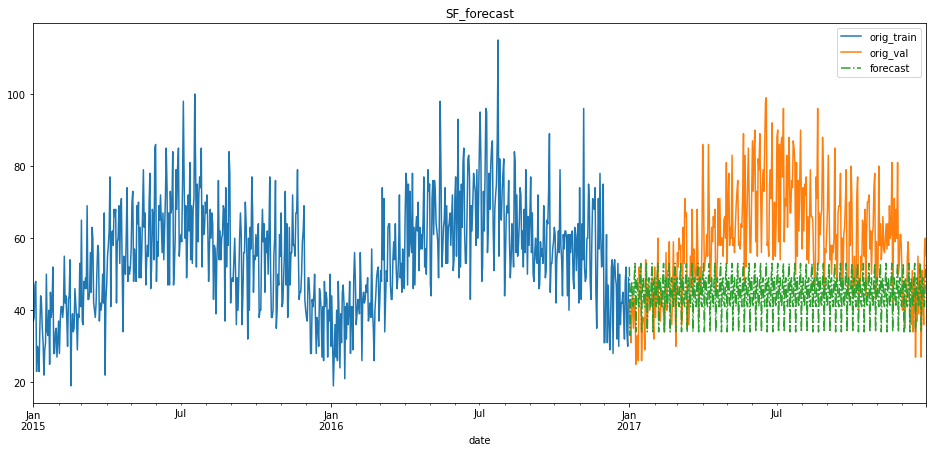

In [26]:
plot_forecast('2015-01-01', train['daymonth_mean_imputed'], val['daymonth_mean_imputed'], val['SF_forecast'], 'SF_forecast')

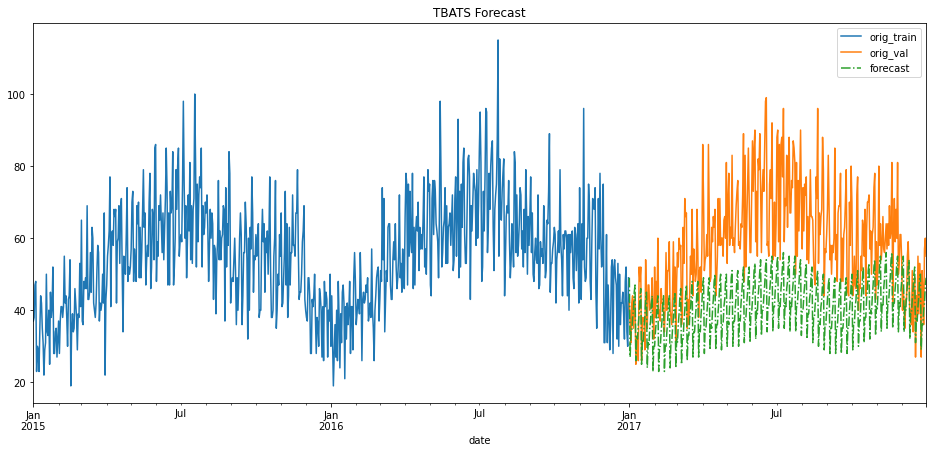

In [27]:
plot_forecast('2015-01-01', train['daymonth_mean_imputed'], val['daymonth_mean_imputed'], val['TBATS_forecast'], 'TBATS Forecast')

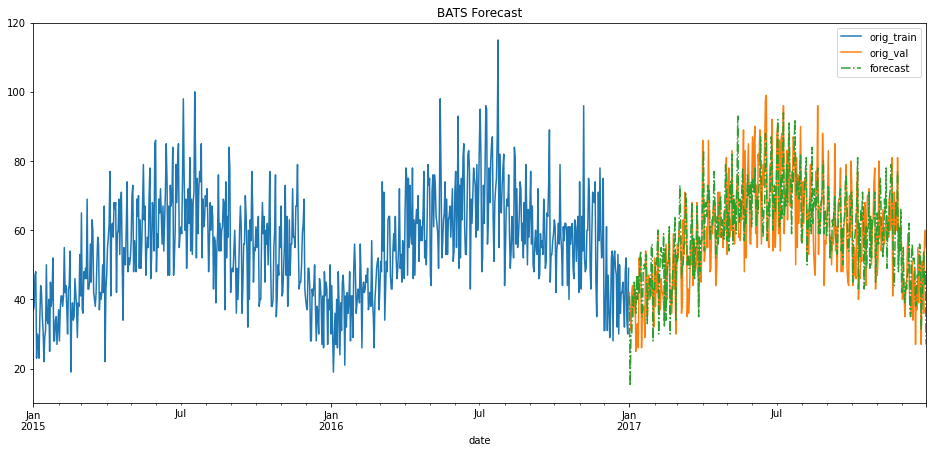

In [28]:
plot_forecast('2015-01-01', train['daymonth_mean_imputed'], val['daymonth_mean_imputed'], val['BATS_forecast'], 'BATS Forecast')

**Nhận xét:**
   - Mô hình SARIMA+Fourier và mô hình TBATS: hai biểu đồ tương ứng với hai mô hình này cho thấy hai mô hình đều nắm bắt được tính chu kỳ theo tuần nhưng không nắm được tính chu kỳ theo năm.
   - Mô hình BATS: biểu đồ cho thấy mô hình đưa ra dự báo khả quan nhất, có thể nắm bắt được mô hình theo tuần và theo năm khá tốt.

### h) Đánh giá performance của các mô hình trên

In [29]:
# Mô hình SARIMA + Fourier
SF_mae = mean_absolute_error(val['SF_forecast'].values, val['daymonth_mean_imputed'].values)
SF_mape = mean_absolute_percentage_error(val['SF_forecast'].values, val['daymonth_mean_imputed'].values)

SF_errors = [SF_mae, SF_mape]

# Mô hình TBATS
tbats_mae = mean_absolute_error(val['TBATS_forecast'].values, val['daymonth_mean_imputed'].values)
tbats_mape = mean_absolute_percentage_error(val['TBATS_forecast'].values, val['daymonth_mean_imputed'].values)


TBATS_errors = [tbats_mae, tbats_mape]

# Mô hình BATS
bats_mae = mean_absolute_error(val['BATS_forecast'].values, val['daymonth_mean_imputed'].values)
bats_mape = mean_absolute_percentage_error(val['BATS_forecast'].values, val['daymonth_mean_imputed'].values)

BATS_errors = [bats_mae, bats_mape]

metrics = ['MAE', 'MAPE']
performance_df = pd.DataFrame({'metrics': metrics, 
                               'SARIMA + Fourier': SF_errors, 
                               'TBATS': TBATS_errors, 
                               'BATS': BATS_errors})
performance_df

,metrics,SARIMA + Fourier,TBATS,BATS
0,MAE,16.169863,18.364384,7.939726
1,MAPE,0.365885,0.452620,0.139928


### k) Kết luận

Trong 3 mô hình trên, mô hình BATS là phù hợp nhất với bộ dữ liệu vì mô hình này thỏa mọi kiểm định về tính chuẩn và tính độc lập của residuals, đồng thời mô hình nắm bắt được tính chu kỳ theo tuần và năm của bộ dữ liệu khá tốt. Bên cạnh đó, sai số dự đoán trung bình của mô hình BATS là thấp nhất so với hai mô hình còn lại.